In [1]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import qiskit
import random
import matplotlib.pyplot as plt
import scipy
import qiskit.providers.aer.noise as noise

from qiskit.quantum_info import Statevector
from qiskit.extensions import HamiltonianGate
from qiskit.circuit.library import MCMT
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer, IBMQ, execute

#from qiskit import IBMQ
#IBMQ.save_account('17d122182eb4e926eb789e55bc17a49c8e19335a70ee99a60213185d0a573876b81b71d8bd70adb55b8c0941b68ed8484b9218787ba2e1349edc2cdb9bbe0c9e')

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional
from scipy.optimize import curve_fit
from qiskit.visualization import plot_histogram, plot_bloch_multivector
n_qubits=5

In [2]:
testing=np.array([[]])

# Definition of the quantum gates

In [3]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
sigma=np.array([np.eye(2,dtype="complex"),X,Y,Z])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

# Actions on circuit (functions for qiskit library)

In [4]:
def qft(circuit, n=n_qubits, start=0, finish=n_qubits-1):
    """Performs qft from qubit start to qubit finish"""
    if n == 0 or finish==start:
        return circuit
    for i in range(int((finish-start+1)/2)):
        circuit.swap(start+i,finish-i)
    for qubit in range(start,finish+1):
        circuit.h(qubit)
        for pair in range(qubit+1,finish+1):
            circuit.cp(np.pi/2**(pair-qubit),qubit,pair)
    return circuit
def qft_d(circuit, n=n_qubits, start=0, finish=n_qubits-1):
    "QFT^\dagger"
    if n == 0 or finish==start:
        return circuit
    for qubit in range(finish,start-1,-1):
        circuit.h(qubit)
        for pair in range(qubit-1,start-1,-1):
            circuit.cp(-np.pi/2**(qubit-pair),qubit,pair)
            circuit.draw("mpl")
    for i in range(int((finish-start+1)/2)):
        circuit.swap(start+i,finish-i)
    return circuit
def qc_two_qubit(state): # return quantum circuit that prepare state from |00>
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    
    #CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0)) 
    parameters=np.array([x1,x2,0,y1,y2,0,z1,z2,-y2])
    qc = QuantumCircuit(2)
    qc.u(parameters[0],parameters[1],parameters[2],0)
    qc.u(parameters[3],parameters[4],parameters[5],1)
    qc.cu(parameters[6],parameters[7],parameters[8],gamma=0,control_qubit=0,target_qubit=1)
    return qc    

# Numpy transformations

In [5]:
def get_psi(n_qubits): #Random state Haar measure
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    psi=psi/np.exp(1j*np.angle(psi[0][0]))
    return psi
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def is_hermit(matrix): #return True if matrix is hermitian
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001
def trace(a):
    return np.trace(a)/len(a)
def convert_base(value, base, length=16,n_qubits=n_qubits):# меняет систему исчесления
    if value < 0:
        value = ( 1<<length ) + value
 
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res
def decompose(A,n_qubits=n_qubits): # разложение на строчки Паули
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters
def compose(parameters,n_qubits=n_qubits): # сборка по параметрам разложения
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A
def Pauli_system(a): #Auxiliary function for Pauli strings decomposition
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 
def write_decomposition(parameters,n_qubits=n_qubits): #write decomposition to Pauli strings and return non-zero strings
    a=""
    b=""
    for i in range(len(parameters)):
        if np.abs(parameters[i])>0.00001:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            b+=Pauli_system(convert_base(i,4,n_qubits=n_qubits))+";"
    return b.split(";")[:-1:]
def Unitaries(decomposition,n_qubits=n_qubits): #return matrices in decomposition (first use decompose function)
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if decomposition[i]!=0:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    if is_hermit(H1) and is_hermit(H2):
        return H1,H2
    else:
        return False
def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A) 
    if is_unitary(U1) and is_unitary(U2):
        return U1,U2
    else:
        return False
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def L(n=n_qubits):
    matrix=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix
def U3gate(x,y,z):
    return np.array([[np.cos(x/2),(-1)*np.exp(1j*z)*np.sin(x/2)],[np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def CU3gate(x,y,z):
    return np.array([[1,0,0,0],[0,1,0,0],[0,0,np.cos(x/2),-np.exp(1j*z)*np.sin(x/2)],[0,0,np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]])
def two_qubit_state(state):
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
        return 0
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    return CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0))
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def rho_fidelity(a,b):
    fidelity=(np.trace(sqrtm(sqrtm(a)@b@sqrtm(a))))**2
    if np.abs(np.imag(fidelity))>0.0000001:
        print("error")
        return 0
    return np.real(fidelity)
def pure_quantum_states_fidelity(a,b):
    return (np.abs(a.T.conjugate()@b)**2)[0][0]   

# Creation matrix A

In [6]:
def create_A(c,n_qubits=n_qubits):
    A=np.zeros((2**n_qubits,2**n_qubits),dtype=complex)
    for i in range(2**n_qubits):
        if i!=(2**n_qubits-1):
            A[i][i+1]=1
        if i!=0:
            A[i][i-1]=1
        A[i][i]=-2-c
    A[0][-1]=1
    A[-1][0]=1
    return A

In [61]:
c=0# thermal conductivity coefficient
A=create_A(c)
A_F=np.round(QFT()@A@(QFT().T.conjugate()),10)
A_F_shift=A_F
for i in range(2**(n_qubits-1)):
    A_F_shift=L()@A_F_shift@(L().T.conjugate())
A_new_F_shift=np.diag(np.array([-c-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)]))
A_new_F=A_new_F_shift
for i in range(2**(n_qubits-1)):
    A_new_F=L()@A_new_F@(L().T.conjugate())
A_new=QFT().T.conjugate()@A_new_F@QFT()

#pseudo inversed matrix or inversed matrix
if c==0:
    val,vec=np.linalg.eigh(A)
    val=np.array([1/val[i] for i in range(len(val)-1)])
    val=np.append(val,0.)
    A_1=vec@np.diag(val)@vec.T
    #approximation matrix
    val=np.linalg.eigh(A_new)[0]
    val=np.array([1/val[i] for i in range(len(val)-1)])
    val=np.append(val,0.)
    A_new_1=vec@np.diag(val)@vec.T
else:
    A_1=np.linalg.inv(A)
    #approximation matrix
    A_new_1=np.linalg.inv(A_new)

# Finding expected tree depth (length of Pauli strings decomposition of pseudo inversed A_new_F)

In [62]:
%%time
if c!=0:
    A_new_F_1=np.diag(np.array([1/(A_new_F[i][i]) for i in range(2**n_qubits)]))
    decomposition=np.round(decompose(A_new_F_1),3)
    print("expected tree depth = ",len(decomposition[decomposition!=0]))
else:
    expected_tree_depth=np.array([])
    for i in range(10):
        A_new_F_1=np.diag(np.array([np.random.random()*25]+[1/(A_new_F[i][i]) for i in range(1,2**n_qubits)]))
        decomposition=np.round(decompose(A_new_F_1),0)
        expected_tree_depth=np.append(expected_tree_depth,len(decomposition[decomposition!=0]))
        if len(decomposition[decomposition!=0])==2**(n_qubits-1):
            min_decomposition=decompose(A_new_F_1)
            print(min_decomposition[min_decomposition!=0])
            

        print(len(decomposition[decomposition!=0]))
#     print("expected tree depth = ",int(expected_tree_depth.min()))

24
24
32
24
24
28
32
32
32
32
Wall time: 3.4 s


In [63]:
for i in range(10):
    test=np.random.random()*2
    A_new_F_shift_test=np.diag(np.array([-test-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)]))
    A_new_F_test=A_new_F_shift_test
    for i in range(2**(n_qubits-1)):
        A_new_F_test=L()@A_new_F_test@(L().T.conjugate())
    
    A_new_F_1=np.diag(np.array([1/(A_new_F_test[i][i]) for i in range(2**n_qubits)]))
    decomposition=np.round(decompose(A_new_F_1),2)
    print("expected tree depth = ",len(decomposition[decomposition!=0]),"c = ",np.round(test,2))

expected tree depth =  32 c =  0.07
expected tree depth =  19 c =  0.68
expected tree depth =  18 c =  0.77
expected tree depth =  15 c =  1.02
expected tree depth =  31 c =  0.14
expected tree depth =  19 c =  0.68
expected tree depth =  26 c =  0.45
expected tree depth =  18 c =  0.8
expected tree depth =  13 c =  1.07
expected tree depth =  18 c =  0.79


In [47]:
decomposition[decomposition!=0]

array([-2.+0.j,  2.+0.j,  1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,
        2.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,  2.+0.j, -1.+0.j,  2.+0.j,
        1.+0.j,  1.+0.j,  1.+0.j,  1.+0.j, -1.+0.j,  2.+0.j, -2.+0.j,
        2.+0.j,  1.+0.j,  1.+0.j, -2.+0.j,  2.+0.j,  1.+0.j,  1.+0.j,
        1.+0.j,  1.+0.j, -1.+0.j,  2.+0.j])

# Graphix

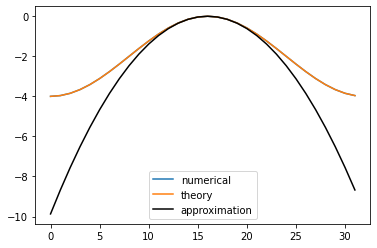

In [10]:
plt.plot(np.diag(np.real(A_F_shift)))
plt.plot(np.array([-c-4*np.cos(np.pi*i/2**n_qubits)**2 for i in range(2**n_qubits)]))
plt.plot(np.diag(A_new_F_shift),color="black")
plt.legend(["numerical","theory","approximation"])
plt.show()

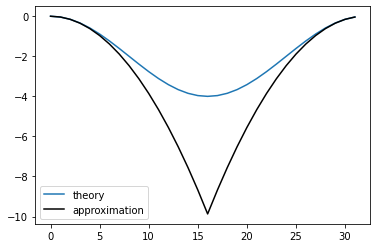

In [11]:
plt.plot(np.diag(np.real(A_F)))
plt.plot(np.real(np.diag(A_new_F)),color="black")
plt.legend(["theory","approximation"])
plt.show()

C:\Users\Юзер\AppData\Local\Temp\ipykernel_19064\4166288939.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


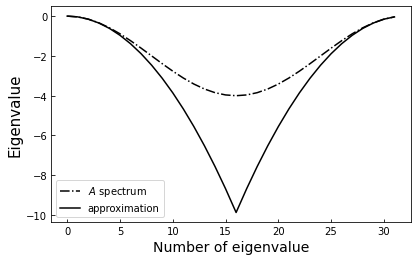

In [12]:
fig = plt.figure(figsize=(5,3))
ax = fig.add_axes((0,0,1,1))
ax.plot(np.diag(np.real(A_F)), '-.',color="black")
ax.plot(np.real(np.diag(A_new_F)),"-",color="black")
ax.set_xlabel(r'Number of eigenvalue',fontsize=14)
ax.set_ylabel(r'Eigenvalue',fontsize=15)
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.legend([r"$A$ spectrum",r"approximation"])
fig.savefig("Spectrum.pdf", bbox_inches='tight')
fig.show()

# DEBUG